# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Libraries

In [ ]:
!nvidia-smi # Run this to see what GPU you have

Sat Oct 19 14:29:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.5/314.5 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 4.3 MB/s eta 0:00:00


In [ ]:
import torch
from torchsummary import summary
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import torch.nn as nn
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv
from torch.utils.data import default_collate
from torchvision.transforms import v2
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import v2


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [ ]:
#from google.colab import drive # Link to your drive if you are not using Colab with GCP
#drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

# Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"skandv","key":"a290ff562f3888fb78632ca4cf208766"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73248 sha256=845a223283c80ad1784022d12c6851a96ba2fa8fe9ed7a5f0558372866828be2
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
# # Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw-2-p-2-face-verification-fall-2024
!unzip -qo '11785-hw-2-p-2-face-verification-fall-2024.zip' -d '/content/data'


 99% 2.74G/2.75G [00:12<00:00, 256MB/s]
100% 2.75G/2.75G [00:13<00:00, 227MB/s]


In [ ]:
!ls '/content/data'

11-785-f24-hw2p2-verification


# Config

In [ ]:
config = {
    'batch_size': 256, # Increase this if your GPU can handle it
    'lr': 0.01, #0.0001,
    'epochs': 20,
   # 'optimizer': {
    #    'name': 'AdamW',
    #},
    #'label_smoothing': 0.1,
    'data_dir': "/content/data/11-785-f24-hw2p2-verification/cls_data", #TODO
    'data_ver_dir': "/content/data/11-785-f24-hw2p2-verification/ver_data", #TODO
    'checkpoint_dir': "/content/data/11-785-f24-hw2p2-verification/checkpoints" #TODO
    # Include other parameters as needed.
}

In [ ]:
import os

checkpoint_dir = config['checkpoint_dir']
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Dataset

## Dataset Class for doing Image Verification

In [ ]:
class ImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2, match = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2), int(match)

In [ ]:
class TestImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2 = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2)

## Create Dataloaders for Image Recognition

In [ ]:
data_dir = config['data_dir']
# train_dir = os.path.join(data_dir)

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'dev')


train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112),  torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.3, hue=0.1),
    torchvision.transforms.RandomRotation(degrees=5),  torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    torchvision.transforms.GaussianBlur(kernel_size=(3, 3)),  torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


val_transforms = torchvision.transforms.Compose([ torchvision.transforms.Resize(112), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)


val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transforms)



cutmix = v2.CutMix(num_classes=len(train_dataset.classes), alpha=0.8)
from torch.utils.data import default_collate

def collate_fn(batch):
    return cutmix(*default_collate(batch))
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=config["batch_size"],
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=4,
                                            sampler=None)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=False,
                                          num_workers=4)


print(f"Train directory: {train_dir}")
print(f"Validation directory: {val_dir}")


Train directory: /content/data/11-785-f24-hw2p2-verification/cls_data/train
Validation directory: /content/data/11-785-f24-hw2p2-verification/cls_data/dev


In [ ]:
!ls /content/data/11-785-f24-hw2p2-verification/val_pairs.txt

/content/data/11-785-f24-hw2p2-verification/val_pairs.txt


In [ ]:
!ls /content/data/11-785-f24-hw2p2-verification/test_pairs.txt

/content/data/11-785-f24-hw2p2-verification/test_pairs.txt


In [ ]:
data_dir = config['data_ver_dir']


# get datasets

# TODO: Add your validation pair txt file
pair_dataset = ImagePairDataset(data_dir, csv_file='/content/data/11-785-f24-hw2p2-verification/val_pairs.txt', transform=val_transforms)
pair_dataloader = torch.utils.data.DataLoader(pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# TODO: Add your validation pair txt file
test_pair_dataset = TestImagePairDataset(data_dir, csv_file=os.path.join(data_dir, '/content/data/11-785-f24-hw2p2-verification/test_pairs.txt'), transform=val_transforms)
test_pair_dataloader = torch.utils.data.DataLoader(test_pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# EDA and Viz

In [ ]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", val_loader.__len__())

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  256
Train batches        :  1686
Val batches          :  169


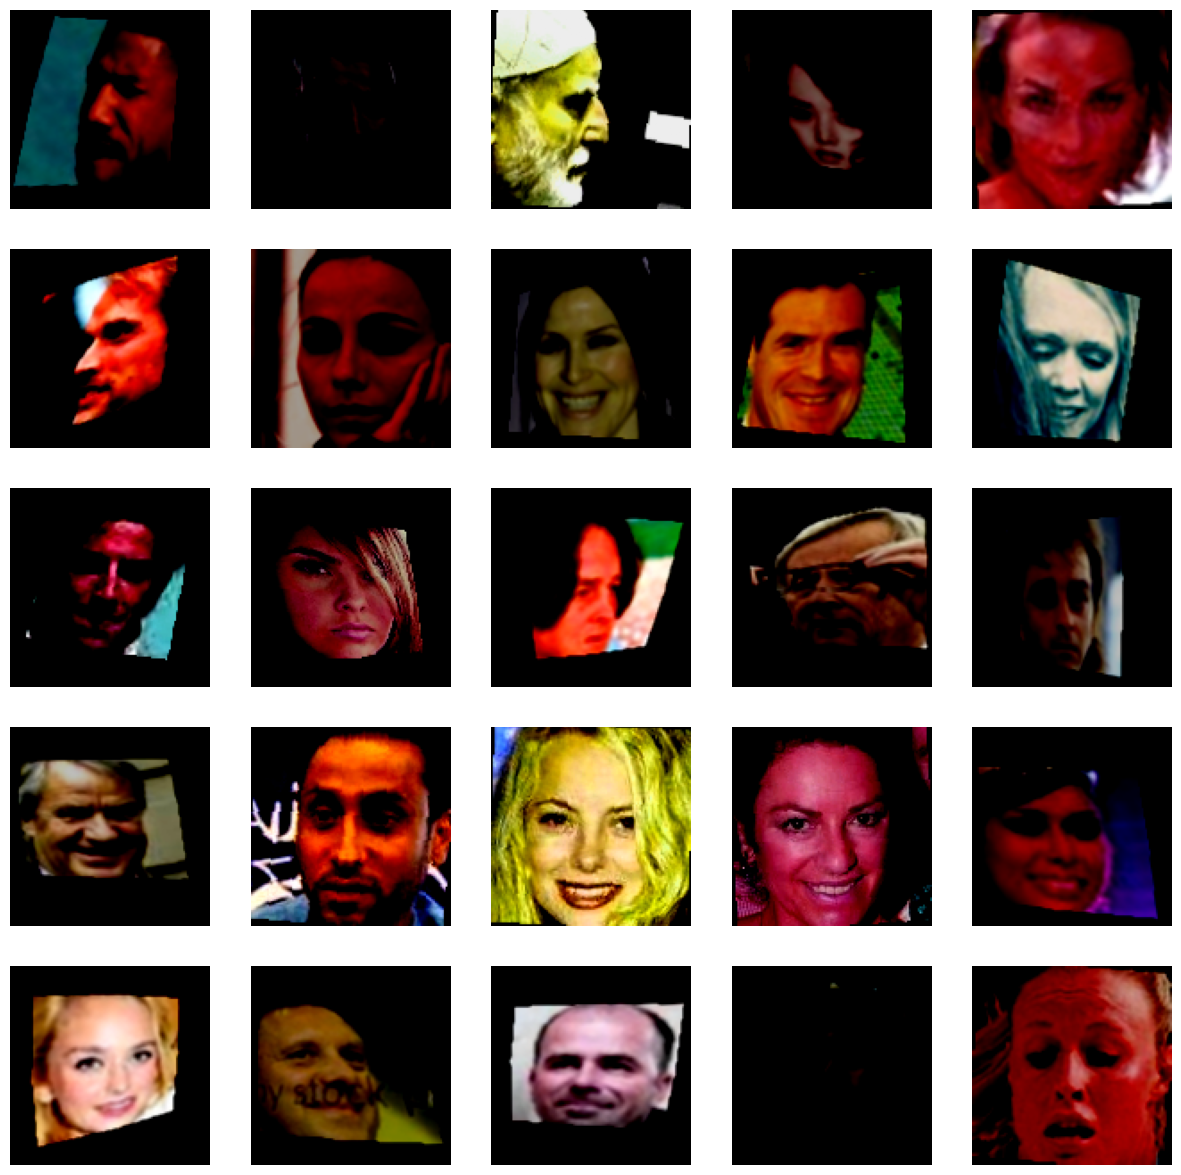

In [ ]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(train_dir, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


.

---------------------------------------------
Started with RESNET101 to achieve the Low Cut off
, Used RESNET18 to achieve high cutoff




In [ ]:
import torch
import torch.nn as nn

class ResidualUnit(nn.Module):
    def __init__(self,
                 in_ch,
                 out_ch,
                 s=1):
        super(ResidualUnit, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_ch,
                                     out_ch,
                                     kernel_size=3,
                                     stride=s,
                                     padding=1,
                                     bias=False)

        self.batch_norm1 = nn.BatchNorm2d(out_ch)
        self.activation = nn.ReLU(inplace=True)

        self.conv_layer2 = nn.Conv2d(out_ch,
                                     out_ch,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1,
                                     bias=False)

        self.batch_norm2 = nn.BatchNorm2d(out_ch)

        self.shortcut = nn.Sequential()
        if s != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch,
                          out_ch,
                          kernel_size=1,
                          stride=s,
                          bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        skip = self.shortcut(x)
        out = self.activation(self.batch_norm1(self.conv_layer1(x)))
        out = self.batch_norm2(self.conv_layer2(out))
        out += skip
        out = self.activation(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, n_classes=8631):
        super(CustomResNet, self).__init__()

        self.initial_channels = 64

        # Initial convolutional layer
        self.conv_initial = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm_initial = nn.BatchNorm2d(64)
        self.activation = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Units
        self.layer1 = self._create_layer(ResidualUnit, 64, 2, s=1)
        self.layer2 = self._create_layer(ResidualUnit, 128, 2, s=2)
        self.layer3 = self._create_layer(ResidualUnit, 256, 2, s=2)
        self.layer4 = self._create_layer(ResidualUnit, 512, 2, s=2)

        # Adaptive pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.output_layer = nn.Linear(512, n_classes)

    def forward(self, x):
        # Initial conv and pooling
        x = self.conv_initial(x)
        x = self.batch_norm_initial(x)
        x = self.activation(x)
        x = self.pool(x)

        # Residual units
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Pooling and classification
        features = self.global_pool(x)
        features = self.flatten(features)
        output = self.output_layer(features)

        return {"features": features, "output": output}

    def _create_layer(self, unit, out_ch, n_units, s):
        blocks = [unit(self.initial_channels, out_ch, s)]
        self.initial_channels = out_ch
        for _ in range(1, n_units):
            blocks.append(unit(self.initial_channels, out_ch))
        return nn.Sequential(*blocks)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CustomResNet(n_classes=8631).to(DEVICE)

# Optionally print the model summary
# from torchsummary import summary
# summary(model, (3, 112, 112))


In [ ]:
import math
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

class CosineAnnealingWarmRestartsDecay(CosineAnnealingWarmRestarts):
    def __init__(self, optimizer, T_0, T_mult=1,
                    eta_min=0, last_epoch=-1, verbose=False, decay=1):
        super().__init__(optimizer, T_0, T_mult=T_mult,
                            eta_min=eta_min, last_epoch=last_epoch, verbose=verbose)
        self.decay = decay
        self.initial_lrs = self.base_lrs

    def step(self, epoch=None):
        if epoch == None:
            if self.T_cur + 1 == self.T_i:
                if self.verbose:
                    print("multiplying base_lrs by {:.4f}".format(self.decay))
                self.base_lrs = [base_lr * self.decay for base_lr in self.base_lrs]
        else:
            if epoch < 0:
                raise ValueError("Expected non-negative epoch, but got {}".format(epoch))
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    n = int(epoch / self.T_0)
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
            else:
                n = 0

            self.base_lrs = [initial_lrs * (self.decay**n) for initial_lrs in self.initial_lrs]

        super().step(epoch)

Trie Different schedulers and optimizers.
For Low Cutoff: CosineAnnealingWarmRestarts is used
For High Cut off :ReduceLROnPlateau

Although I used ReduceLROnPlateau intially but it didnt go well as I didnt used threshold and mode.

In [ ]:
# --------------------------------------------------- #
import torch.nn.functional as F

# Define criterion with label smoothing
#label_smoothing_eps = 0.1  # Adjust this value as needed


# Defining Loss function
#criterion = # TODO: What loss do you need for a multi class classification problem and would label smoothing be beneficial here?
#criterion =  nn.CrossEntropyLoss(label_smoothing=0.1)
#criterion = torch.nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)# TODO: What loss do you need for a multi class classification problem and would label smoothing be beneficial here?



# --------------------------------------------------- #

# Defining Optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # TODO: Feel free to pick a optimizer
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4,)
#optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # TODO: Feel free to pick a optimizer


# --------------------------------------------------- #

# Defining Scheduler
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True) #ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)  # Adjust T_max based on epochs
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-4, step_size_up=2000, mode='triangular')
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)
# Replace the current scheduler
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=config['scheduler']['T_0'], T_mult=config['scheduler']['T_mult'], eta_min=config['scheduler']['eta_min'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=1e-1, factor= 0.5, patience=5, mode='min')# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.

# --------------------------------------------------- #

scaler = torch.amp.GradScaler()

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
#scaler = torch.cuda.amp.GradScaler()

# Metrics

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [ ]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [ ]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.cuda.amp.autocast():
            loss = criterion(outputs['output'], labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'features' in outputs:
            acc = accuracy(outputs['output'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    if lr_scheduler is not None:
        if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            pass
        else:
            lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [ ]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['output'], labels)

        # metrics
        acc = accuracy(outputs['output'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# Verification Task

In [ ]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['features'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC']

# WandB

Project Ablations Report Link : https://api.wandb.ai/links/skandv-carnegie-mellon-university/6krkcecg

In [ ]:
wandb.login(key="f9cf09dac50889564c1f8fb34fff472412382ff7") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "RESNET18", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: Currently logged in as: skandv (skandv-carnegie-mellon-university). Use `wandb login --relogin` to force relogin


# Checkpointing and Loading Model

In [ ]:
# Uncomment the line for saving the scheduler save dict if you are using a scheduler
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
          'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

# Experiments

In [ ]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })

        # retrieval validation
        valid_ret_acc = valid_epoch_ver(model, pair_dataloader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                # wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            # wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 1/20: 
Train Cls. Acc 0.2480%	 Train Cls. Loss 8.2663	 Learning Rate 0.0100


Val Cls. Acc 0.7893%	 Val Cls. Loss 7.6742


{'ACC': 74.7, 'EER': 25.933202357407826, 'AUC': 82.91366402714479, 'TPRs': [('TPR@FPR=1e-4', 5.295315682281059), ('TPR@FPR=5e-4', 5.295315682281059), ('TPR@FPR=1e-3', 5.295315682281059), ('TPR@FPR=5e-3', 12.627291242362526), ('TPR@FPR=5e-2', 37.88187372708758)]}
Val Ret. Acc 74.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 2/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 2/20: 
Train Cls. Acc 2.1637%	 Train Cls. Loss 7.1890	 Learning Rate 0.0100


Val Cls. Acc 4.2198%	 Val Cls. Loss 6.7114


{'ACC': 79.3, 'EER': 21.588594704682205, 'AUC': 87.73362569472509, 'TPRs': [('TPR@FPR=1e-4', 13.441955193482688), ('TPR@FPR=5e-4', 13.441955193482688), ('TPR@FPR=1e-3', 13.441955193482688), ('TPR@FPR=5e-3', 24.03258655804481), ('TPR@FPR=5e-2', 55.193482688391036)]}
Val Ret. Acc 79.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 3/20: 
Train Cls. Acc 7.9601%	 Train Cls. Loss 6.2779	 Learning Rate 0.0100


Val Cls. Acc 10.6787%	 Val Cls. Loss 5.9837


{'ACC': 82.7, 'EER': 17.922606924643578, 'AUC': 90.26324529147442, 'TPRs': [('TPR@FPR=1e-4', 21.792260692464357), ('TPR@FPR=5e-4', 21.792260692464357), ('TPR@FPR=1e-3', 21.792260692464357), ('TPR@FPR=5e-3', 31.160896130346234), ('TPR@FPR=5e-2', 59.063136456211815)]}
Val Ret. Acc 82.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 4/20: 
Train Cls. Acc 16.0813%	 Train Cls. Loss 5.5921	 Learning Rate 0.0100


Val Cls. Acc 20.5425%	 Val Cls. Loss 5.2614


{'ACC': 86.0, 'EER': 14.256619144602862, 'AUC': 92.56679164049152, 'TPRs': [('TPR@FPR=1e-4', 21.58859470468432), ('TPR@FPR=5e-4', 21.58859470468432), ('TPR@FPR=1e-3', 21.58859470468432), ('TPR@FPR=5e-3', 35.234215885947044), ('TPR@FPR=5e-2', 67.0061099796334)]}
Val Ret. Acc 86.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 5/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 5/20: 
Train Cls. Acc 25.2048%	 Train Cls. Loss 5.0188	 Learning Rate 0.0100


Val Cls. Acc 27.3756%	 Val Cls. Loss 4.9060


{'ACC': 87.0, 'EER': 13.359528487201095, 'AUC': 93.41986803724406, 'TPRs': [('TPR@FPR=1e-4', 33.604887983706725), ('TPR@FPR=5e-4', 33.604887983706725), ('TPR@FPR=1e-3', 33.604887983706725), ('TPR@FPR=5e-3', 42.973523421588595), ('TPR@FPR=5e-2', 69.85743380855396)]}
Val Ret. Acc 87.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 6/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 6/20: 
Train Cls. Acc 33.7112%	 Train Cls. Loss 4.5500	 Learning Rate 0.0100


Val Cls. Acc 31.3957%	 Val Cls. Loss 4.6524


{'ACC': 86.9, 'EER': 14.460285132382872, 'AUC': 93.27061968077658, 'TPRs': [('TPR@FPR=1e-4', 34.623217922606926), ('TPR@FPR=5e-4', 34.623217922606926), ('TPR@FPR=1e-3', 34.623217922606926), ('TPR@FPR=5e-3', 42.36252545824847), ('TPR@FPR=5e-2', 76.17107942973523)]}
Val Ret. Acc 86.9000%
Saved epoch model
Saved best classification model

Epoch 7/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 7/20: 
Train Cls. Acc 41.1879%	 Train Cls. Loss 4.1632	 Learning Rate 0.0100


Val Cls. Acc 42.1833%	 Val Cls. Loss 4.1188


{'ACC': 87.8, 'EER': 12.423625254589709, 'AUC': 93.8724146623506, 'TPRs': [('TPR@FPR=1e-4', 31.364562118126273), ('TPR@FPR=5e-4', 31.364562118126273), ('TPR@FPR=1e-3', 31.364562118126273), ('TPR@FPR=5e-3', 40.32586558044807), ('TPR@FPR=5e-2', 76.37474541751527)]}
Val Ret. Acc 87.8000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 8/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 8/20: 
Train Cls. Acc 47.5837%	 Train Cls. Loss 3.8469	 Learning Rate 0.0100


Val Cls. Acc 42.2636%	 Val Cls. Loss 4.0836


{'ACC': 88.3, 'EER': 12.966601178738085, 'AUC': 94.47941132927068, 'TPRs': [('TPR@FPR=1e-4', 50.71283095723014), ('TPR@FPR=5e-4', 50.71283095723014), ('TPR@FPR=1e-3', 50.71283095723014), ('TPR@FPR=5e-3', 55.193482688391036), ('TPR@FPR=5e-2', 78.61507128309573)]}
Val Ret. Acc 88.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 9/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 9/20: 
Train Cls. Acc 53.1850%	 Train Cls. Loss 3.5822	 Learning Rate 0.0100


Val Cls. Acc 52.4150%	 Val Cls. Loss 3.6343


{'ACC': 87.3, 'EER': 12.770137524599361, 'AUC': 94.5810442583397, 'TPRs': [('TPR@FPR=1e-4', 50.71283095723014), ('TPR@FPR=5e-4', 50.71283095723014), ('TPR@FPR=1e-3', 50.71283095723014), ('TPR@FPR=5e-3', 51.73116089613035), ('TPR@FPR=5e-2', 76.37474541751527)]}
Val Ret. Acc 87.3000%
Saved epoch model
Saved best classification model

Epoch 10/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 10/20: 
Train Cls. Acc 57.8208%	 Train Cls. Loss 3.3640	 Learning Rate 0.0100


Val Cls. Acc 55.9218%	 Val Cls. Loss 3.4774


{'ACC': 88.0, 'EER': 12.423625254582678, 'AUC': 95.44692480363638, 'TPRs': [('TPR@FPR=1e-4', 56.61914460285132), ('TPR@FPR=5e-4', 56.61914460285132), ('TPR@FPR=1e-3', 56.61914460285132), ('TPR@FPR=5e-3', 65.37678207739307), ('TPR@FPR=5e-2', 78.81873727087576)]}
Val Ret. Acc 88.0000%
Saved epoch model
Saved best classification model

Epoch 11/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 11/20: 
Train Cls. Acc 61.6972%	 Train Cls. Loss 3.1811	 Learning Rate 0.0100


Val Cls. Acc 57.7593%	 Val Cls. Loss 3.3869


{'ACC': 89.8, 'EER': 10.794297352342165, 'AUC': 95.59617316010387, 'TPRs': [('TPR@FPR=1e-4', 46.84317718940937), ('TPR@FPR=5e-4', 46.84317718940937), ('TPR@FPR=1e-3', 46.84317718940937), ('TPR@FPR=5e-3', 51.73116089613035), ('TPR@FPR=5e-2', 84.11405295315683)]}
Val Ret. Acc 89.8000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 12/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 12/20: 
Train Cls. Acc 64.9492%	 Train Cls. Loss 3.0319	 Learning Rate 0.0100


Val Cls. Acc 61.0894%	 Val Cls. Loss 3.2299


{'ACC': 89.3, 'EER': 10.997963340119458, 'AUC': 95.30727955857698, 'TPRs': [('TPR@FPR=1e-4', 37.88187372708758), ('TPR@FPR=5e-4', 37.88187372708758), ('TPR@FPR=1e-3', 37.88187372708758), ('TPR@FPR=5e-3', 63.951120162932796), ('TPR@FPR=5e-2', 80.24439918533605)]}
Val Ret. Acc 89.3000%
Saved epoch model
Saved best classification model

Epoch 13/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 13/20: 
Train Cls. Acc 67.8593%	 Train Cls. Loss 2.8995	 Learning Rate 0.0100


Val Cls. Acc 63.9676%	 Val Cls. Loss 3.0952


{'ACC': 90.3, 'EER': 10.386965376782081, 'AUC': 96.10273728688095, 'TPRs': [('TPR@FPR=1e-4', 43.9918533604888), ('TPR@FPR=5e-4', 43.9918533604888), ('TPR@FPR=1e-3', 43.9918533604888), ('TPR@FPR=5e-3', 60.28513238289206), ('TPR@FPR=5e-2', 83.91038696537679)]}
Val Ret. Acc 90.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 14/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 14/20: 
Train Cls. Acc 70.3216%	 Train Cls. Loss 2.7884	 Learning Rate 0.0100


Val Cls. Acc 66.5222%	 Val Cls. Loss 2.9954


{'ACC': 89.4, 'EER': 11.201629327903856, 'AUC': 95.47333336000865, 'TPRs': [('TPR@FPR=1e-4', 42.76985743380855), ('TPR@FPR=5e-4', 42.76985743380855), ('TPR@FPR=1e-3', 42.76985743380855), ('TPR@FPR=5e-3', 51.5274949083503), ('TPR@FPR=5e-2', 82.89205702647658)]}
Val Ret. Acc 89.4000%
Saved epoch model
Saved best classification model

Epoch 15/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 15/20: 
Train Cls. Acc 72.4461%	 Train Cls. Loss 2.6934	 Learning Rate 0.0100


Val Cls. Acc 67.0790%	 Val Cls. Loss 2.9494


{'ACC': 90.3, 'EER': 10.01964636547702, 'AUC': 96.03551550702429, 'TPRs': [('TPR@FPR=1e-4', 41.75152749490835), ('TPR@FPR=5e-4', 41.75152749490835), ('TPR@FPR=1e-3', 41.75152749490835), ('TPR@FPR=5e-3', 60.28513238289206), ('TPR@FPR=5e-2', 81.4663951120163)]}
Val Ret. Acc 90.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 16/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 16/20: 
Train Cls. Acc 74.3201%	 Train Cls. Loss 2.6073	 Learning Rate 0.0100


Val Cls. Acc 69.4870%	 Val Cls. Loss 2.8521


{'ACC': 90.6, 'EER': 9.82318271110611, 'AUC': 95.76182683189354, 'TPRs': [('TPR@FPR=1e-4', 38.90020366598778), ('TPR@FPR=5e-4', 38.90020366598778), ('TPR@FPR=1e-3', 38.90020366598778), ('TPR@FPR=5e-3', 54.78615071283096), ('TPR@FPR=5e-2', 83.5030549898167)]}
Val Ret. Acc 90.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 17/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 17/20: 
Train Cls. Acc 75.9600%	 Train Cls. Loss 2.5340	 Learning Rate 0.0100


Val Cls. Acc 69.3350%	 Val Cls. Loss 2.8568


{'ACC': 90.1, 'EER': 10.386965376782063, 'AUC': 96.37242466559167, 'TPRs': [('TPR@FPR=1e-4', 45.21384928716905), ('TPR@FPR=5e-4', 45.21384928716905), ('TPR@FPR=1e-3', 45.21384928716905), ('TPR@FPR=5e-3', 64.15478615071282), ('TPR@FPR=5e-2', 83.70672097759673)]}
Val Ret. Acc 90.1000%
Saved epoch model

Epoch 18/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 18/20: 
Train Cls. Acc 77.5259%	 Train Cls. Loss 2.4662	 Learning Rate 0.0100


Val Cls. Acc 71.7144%	 Val Cls. Loss 2.7582


{'ACC': 90.0, 'EER': 10.609037328038147, 'AUC': 96.33001092353923, 'TPRs': [('TPR@FPR=1e-4', 53.97148676171079), ('TPR@FPR=5e-4', 53.97148676171079), ('TPR@FPR=1e-3', 53.97148676171079), ('TPR@FPR=5e-3', 60.896130346232184), ('TPR@FPR=5e-2', 84.5213849287169)]}
Val Ret. Acc 90.0000%
Saved epoch model
Saved best classification model

Epoch 19/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 19/20: 
Train Cls. Acc 78.8920%	 Train Cls. Loss 2.4067	 Learning Rate 0.0100


Val Cls. Acc 71.7106%	 Val Cls. Loss 2.7591


{'ACC': 91.2, 'EER': 9.36863543788187, 'AUC': 96.6577171003405, 'TPRs': [('TPR@FPR=1e-4', 53.360488798370675), ('TPR@FPR=5e-4', 53.360488798370675), ('TPR@FPR=1e-3', 53.360488798370675), ('TPR@FPR=5e-3', 62.729124236252545), ('TPR@FPR=5e-2', 85.94704684317719)]}
Val Ret. Acc 91.2000%
Saved epoch model
Saved best retrieval model

Epoch 20/20


Train:   0%|          | 0/1686 [00:00<?, ?it/s]<ipython-input-76-efb5c17fa731>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 20/20: 
Train Cls. Acc 80.2480%	 Train Cls. Loss 2.3503	 Learning Rate 0.0100


Val Cls. Acc 72.3981%	 Val Cls. Loss 2.7208


{'ACC': 91.0, 'EER': 9.572301425663616, 'AUC': 96.44604851972039, 'TPRs': [('TPR@FPR=1e-4', 56.0081466395112), ('TPR@FPR=5e-4', 56.0081466395112), ('TPR@FPR=1e-3', 56.0081466395112), ('TPR@FPR=5e-3', 64.96945010183299), ('TPR@FPR=5e-2', 84.928716904277)]}
Val Ret. Acc 91.0000%
Saved epoch model
Saved best classification model


# Testing and Kaggle Submission (Verification)

In [ ]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['features'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [ ]:
scores = test_epoch_ver(model, test_pair_dataloader, config)

In [ ]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [ ]:
### Finish your wandb run
run.finish()

train_cls_acc,▁▁▂▂▃▄▅▅▆▆▆▇▇▇▇▇████
train_loss,█▇▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁
valid_cls_acc,▁▁▂▃▄▄▅▅▆▆▇▇▇▇▇█████
valid_loss,█▇▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁
valid_ret_acc,▁▃▄▆▆▆▇▇▆▇▇▇█▇███▇██
train_cls_acc,80.24799
train_loss,2.35031
valid_cls_acc,72.39808
valid_loss,2.72075
valid_ret_acc,91
